In [34]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('../../../'))
sys.path.insert(0, os.path.abspath('../../../../'))

In [35]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *
from matplotlib import pyplot as plt

from shared.gem.gem_instance import GEMInstance
from shared.gem.gem_quantum_instance import GEMQuantumInstance

%matplotlib inline

ibmqfactory.load_account:WARNING:2021-10-22 12:59:53,234: Credentials are already in use. The existing account in the session will be replaced.


graph_05_06_02


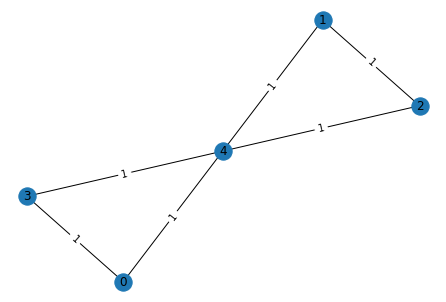

In [36]:
graph = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
print(graph.name)
max_cut.draw()

In [37]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)

In [38]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)
len(a_gamma)

32

In [39]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i,j,w in graph.edges.data('weight'):
        if x[i] != x[j]:
            obj -= w
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [40]:
import pickle
from qiskit.providers.models import BackendConfiguration

def load_from_pickle(name):
    with open(name, 'rb') as f:
        return pickle.load(f)
    
noise_model_filename = "ibmq_toronto_noise_model_dict.pkl"
noise_model_dict = load_from_pickle(noise_model_filename)
noise_model = NoiseModel.from_dict(noise_model_dict)
basis_gates = noise_model.basis_gates
        
noise_backend_configuration_filename = "ibmq_toronto_noise_backend_configuation_dict.pkl"
noise_backend_configuration_dict = load_from_pickle(noise_backend_configuration_filename)
noise_backend_configuration = BackendConfiguration.from_dict(noise_backend_configuration_dict)
coupling_map = noise_backend_configuration.coupling_map

In [41]:
quantum_instance = GEMQuantumInstance(
                    backend=Aer.get_backend("qasm_simulator"),
                    noise_model=noise_model,
                    coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    shots=1024)

qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1
            )

op, offset = max_cut_qubo.to_ising()

In [42]:
def create_cirucit(gamma,beta):
    circuits = qaoa.construct_circuit([gamma,beta], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [43]:
gem_instance = GEMInstance()

In [44]:
first_circuit = create_cirucit(0.25,0.25)

In [45]:
mg = gem_instance.get_gem_matrix(first_circuit, quantum_instance)

In [46]:
quantum_instance.MG = mg

In [47]:
landscape = np.zeros(a_gamma.shape)

for i in range(0, len(landscape)):
    circuits = []
    for j in range(0, len(landscape)):
        # create circuits for entire row 
        circuit = create_cirucit(a_gamma[i][j], b_beta[i][j])
        circuits.append(circuit)
    
    # create one job with circuits 
    job_name = f"{graph.name}_gem_row_{i}"
    job = quantum_instance.execute(circuits)
    #job.update_name(job_name)
    print(job_name)
    #print(job)
    
    # add results to landscape 
    k = 0
    for count in job.get_counts():
        mean = compute_expectation(count, graph)
        landscape[i,k % 32] = mean
        k += 1

graph_05_06_02_gem_row_0
graph_05_06_02_gem_row_1
graph_05_06_02_gem_row_2
graph_05_06_02_gem_row_3
graph_05_06_02_gem_row_4
graph_05_06_02_gem_row_5
graph_05_06_02_gem_row_6
graph_05_06_02_gem_row_7
graph_05_06_02_gem_row_8
graph_05_06_02_gem_row_9
graph_05_06_02_gem_row_10
graph_05_06_02_gem_row_11
graph_05_06_02_gem_row_12
graph_05_06_02_gem_row_13
graph_05_06_02_gem_row_14
graph_05_06_02_gem_row_15
graph_05_06_02_gem_row_16
graph_05_06_02_gem_row_17
graph_05_06_02_gem_row_18
graph_05_06_02_gem_row_19
graph_05_06_02_gem_row_20
graph_05_06_02_gem_row_21
graph_05_06_02_gem_row_22
graph_05_06_02_gem_row_23
graph_05_06_02_gem_row_24
graph_05_06_02_gem_row_25
graph_05_06_02_gem_row_26
graph_05_06_02_gem_row_27
graph_05_06_02_gem_row_28
graph_05_06_02_gem_row_29
graph_05_06_02_gem_row_30
graph_05_06_02_gem_row_31


[[-2.96204915 -3.00853924 -3.0582293  ... -2.90230861 -2.9604013
  -2.97737526]
 [-3.01241036 -2.96584553 -2.87436435 ... -3.07488642 -3.0368277
  -2.99247251]
 [-3.06085242 -2.72569009 -2.78630383 ... -3.24231214 -3.12624456
  -3.01317826]
 ...
 [-3.01477188 -3.0677422  -3.13830043 ... -2.66123155 -2.73214944
  -2.99122976]
 [-2.85127023 -3.03276078 -3.17578186 ... -2.89955704 -2.92472186
  -2.98260204]
 [-2.83076198 -3.08790542 -3.06179027 ... -2.87521986 -2.90685539
  -3.01955823]]


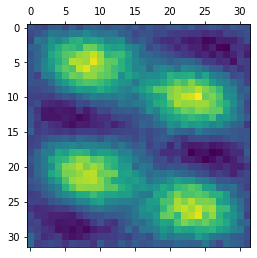

In [48]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [49]:
# Mean of landscape
np.mean(landscape)

-2.751684766023369

In [50]:
# Minimium 
np.min(landscape)

-3.3868062392731866

In [51]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

(18, 26)

In [52]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

Opt.Gamma: 1.8, Opt.Beta: 2.6


In [53]:
# Save result matrix 
with open('landscape_creation_sim_butterfly_no_weights_gem_results.npy', 'wb') as f:
    np.save(f, landscape)

In [54]:
import plotly.graph_objects as go

In [55]:
# Plot landscape in 3D 
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA with GEM- MaxCut-Landscape", scene=dict(
    xaxis_title="γ",
    yaxis_title="β",
    zaxis_title="F(γ,β)"
))

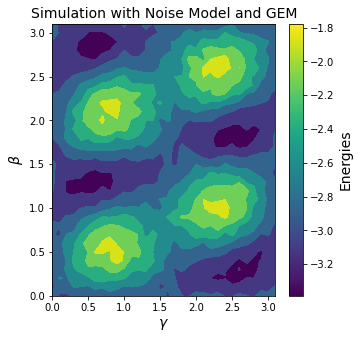

In [56]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

font_size = 14
fig, ax = plt.subplots(1,1, figsize=(5,5))

cmap = cm.get_cmap('viridis')
minv = np.min([landscape])
maxv = np.max([landscape])
normalizer=Normalize(minv,maxv)
im=cm.ScalarMappable(norm=normalizer)

plot = ax.contourf(a_gamma, b_beta, landscape, cmap = cmap, norm=normalizer)
ax.set_ylabel(r'$\beta$', fontsize = font_size)
ax.set_xlabel(r'$\gamma$', fontsize = font_size)
ax.set_title('Simulation with Noise Model and GEM', fontsize = font_size)

colorbar = plt.colorbar(im, ax=ax)
colorbar.ax.set_ylabel('Energies', fontsize = font_size)
plt.show()